In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
import pickle
from elephant.signal_processing import wavelet_transform
from elephant.spectral import welch_psd
import seaborn as sns
sns.set_theme()

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
output_dir = Path.home() / 'Desktop' / 'disk1' / 'ecephys_data'
cache = EcephysProjectCache.from_warehouse(manifest=output_dir / 'manifest.json')
channel_df = cache.get_channels()
probes_df = cache.get_probes()

In [3]:
# 1) Load session with probes in VISp and VISpm

In [4]:
with open('VISpm_VISp_probes.pkl', 'rb') as f:
    probe_list = pickle.load(f)
print('[session_id, VISpm/VISp_probe_1, VISpm/VISp_probe_2]')
probe_list

[session_id, VISpm/VISp_probe_1, VISpm/VISp_probe_2]


[[719161530, 729445650, 729445652],
 [732592105, 733744647, 733744649],
 [754312389, 756781555, 756781557],
 [750332458, 757904547, 757904550],
 [751348571, 757984818, 757984820],
 [737581020, 757988389, 757988391],
 [756029989, 760640087, 760640090],
 [755434585, 760642624, 760642628],
 [761418226, 768908582, 768908585],
 [742951821, 769322714, 769322716],
 [759883607, 769322789, 769322793],
 [750749662, 769322804, 769322806],
 [760693773, 769322824, 769322827],
 [758798717, 770930071, 770930073],
 [767871931, 773462990, 773462993],
 [771160300, 773621939, 773621942],
 [771990200, 773654726, 773654728],
 [778240327, 792607547, 792607549],
 [786091066, 792623919, 792623921],
 [778998620, 792626844, 792626847],
 [779839471, 792645493, 792645497],
 [791319847, 805008602, 805008604],
 [797828357, 805579738, 805579741],
 [760345702, 810753197, 810753199],
 [715093703, 810755799, 810755801],
 [794812542, 810758779, 810758781],
 [821695405, 822645895, 822645897],
 [831882777, 832810576, 8328

In [5]:
# Loading the selected session and determining which probe is VISpm/VISp
selected_session_list = probe_list[0]

session = cache.get_session_data(selected_session_list[0])

if 'VISpm' in probes_df[probes_df.index==selected_session_list[1]].ecephys_structure_acronyms.item():
    selected_VISpm_probe_id = selected_session_list[1]
    selected_VISp_probe_id = selected_session_list[2]
else:
    selected_VISpm_probe_id = selected_session_list[2]
    selected_VISp_probe_id = selected_session_list[1]

In [6]:
VISpm_lfp = session.get_lfp(selected_VISpm_probe_id)
VISp_lfp = session.get_lfp(selected_VISp_probe_id)
VISp_lfp

<xarray.DataArray 'LFP' (time: 12081285, channel: 89)>
array([[-6.2204999e-05, -4.6410001e-05, -5.3039999e-05, ...,
        -2.3400000e-06,  7.7999999e-07, -2.1059999e-05],
       [-4.8555001e-05, -4.5435001e-05, -5.1089999e-05, ...,
         3.5099999e-06,  0.0000000e+00, -3.0224999e-05],
       [-3.0030000e-05, -3.4320001e-05, -3.7049998e-05, ...,
         0.0000000e+00,  9.7500003e-07, -2.0670001e-05],
       ...,
       [ 2.3400000e-05, -4.2705000e-05,  4.3874999e-05, ...,
         2.3594999e-05, -2.6714999e-05,  3.7440001e-05],
       [ 3.7049999e-06, -4.6800000e-05,  4.4655000e-05, ...,
         2.5350000e-05, -3.9000000e-07,  5.7329999e-05],
       [ 1.4040000e-05, -2.8470000e-05,  2.7104999e-05, ...,
         1.5015000e-05, -1.4040000e-05,  2.5350000e-05]], dtype=float32)
Coordinates:
  * time     (time) float64 0.6191 0.6199 0.6207 ... 9.666e+03 9.666e+03
  * channel  (channel) int64 850250811 850250819 ... 850251507 850251515

In [7]:
# 2) Get the 100-300-100s times of the relevant (flash) stimulus block

In [8]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,29.830107,89.896827,60.066720,spontaneous,null
1,89.896827,969.865012,879.968184,gabors,0.0
2,969.865012,982.125255,12.260244,invalid_presentation,NaN
3,982.125255,1001.891772,19.766516,gabors,0.0
4,1001.891772,1290.883097,288.991326,spontaneous,null
5,1290.883097,1589.382401,298.499304,flashes,1.0
6,1589.382401,1591.133857,1.751456,spontaneous,null
7,1591.133857,2190.634543,599.500686,drifting_gratings,2.0
8,2190.634543,2221.660447,31.025904,spontaneous,null
9,2221.660447,2822.161967,600.501520,natural_movie_three,3.0


In [9]:
flash_index = stim_epochs[stim_epochs.stimulus_name=='flashes'].index.item()

print('No stimulus block before flashes:')
print(stim_epochs[stim_epochs.index==flash_index-1])
print('\nFlashes block:')
print(stim_epochs[stim_epochs.index==flash_index])
print('\nNo stimulus block after flashes:')
print(stim_epochs[stim_epochs.index==flash_index+1])

No stimulus block before flashes:
    start_time    stop_time    duration stimulus_name stimulus_block
4  1001.891772  1290.883097  288.991326   spontaneous           null

Flashes block:
    start_time    stop_time    duration stimulus_name stimulus_block
5  1290.883097  1589.382401  298.499304       flashes            1.0

No stimulus block after flashes:
    start_time    stop_time  duration stimulus_name stimulus_block
6  1589.382401  1591.133857  1.751456   spontaneous           null


In [10]:
global_start_time = stim_epochs[stim_epochs.index==flash_index-1].start_time.item()
global_end_time = stim_epochs[stim_epochs.index==flash_index+1].stop_time.item()

spontaneous_before_start_time = global_start_time
spontaneous_before_end_time = stim_epochs[stim_epochs.index==flash_index-1].stop_time.item()

flashes_start_time = stim_epochs[stim_epochs.index==flash_index].start_time.item()
flashes_end_time = stim_epochs[stim_epochs.index==flash_index].stop_time.item()

spontaneous_after_start_time = stim_epochs[stim_epochs.index==flash_index+1].start_time.item()
spontaneous_after_end_time = global_end_time

print(f'Looking at {global_start_time}s - {global_end_time}s time range')

Looking at 1001.8917716749913s - 1591.1338573815906s time range


In [11]:
# 3) Select channels from VISp and VISpm only, select time range defined above only

In [12]:
# Quality check for channels that are in the LFP NWB file but not in the Allen cache
for ch in VISpm_lfp.channel.values:
    if ch not in channel_df.index.to_list():
        VISpm_lfp = VISpm_lfp.drop_sel(channel=ch)
for ch in VISp_lfp.channel.values:
    if ch not in channel_df.index.to_list():
        VISp_lfp = VISp_lfp.drop_sel(channel=ch)

In [13]:
VISpm_channel_ids = [ch for ch in VISpm_lfp.channel.values if channel_df[channel_df.index==ch]['ecephys_structure_acronym'].item()=='VISpm']
VISp_channel_ids = [ch for ch in VISp_lfp.channel.values if channel_df[channel_df.index==ch]['ecephys_structure_acronym'].item()=='VISp']

print(f'VISp channels = {len(VISp_channel_ids)}')
print(f'VISpm channels = {len(VISpm_channel_ids)}')

VISp channels = 22
VISpm channels = 22


In [14]:
# Selecting the channel in VISp and VISpm
VISpm_lfp_slice = VISpm_lfp.sel(channel=slice(VISpm_channel_ids[0], VISpm_channel_ids[-1]))
VISp_lfp_slice = VISp_lfp.sel(channel=slice(VISp_channel_ids[0], VISp_channel_ids[-1]))

In [15]:
VISpm_lfp_slice = VISpm_lfp_slice.sel(time=slice(global_start_time, global_end_time))
VISp_lfp_slice = VISp_lfp_slice.sel(time=slice(global_start_time, global_end_time))

In [16]:
# 4) Plot the LFP signal from all channels from VISp and VISpm side by side. Choose channel with maximum signal

In [17]:
def get_max_channel_id(data):
    max_amplitudes = np.max(np.abs(data), axis=0)
    return int(np.argmax(max_amplitudes.data))

def get_max_channel_id_list(data):
    max_amplitudes = np.max(np.abs(data), axis=0)
    return np.argsort(-max_amplitudes).data

In [18]:
VISpm_max_channel = VISpm_channel_ids[get_max_channel_id(VISpm_lfp_slice)]
VISp_max_channel = VISp_channel_ids[get_max_channel_id(VISp_lfp_slice)]
print(f'VISpm_max_channel = {VISpm_max_channel}')
print(f'VISp_max_channel = {VISp_max_channel}')

VISpm_max_channel_list = get_max_channel_id_list(VISpm_lfp_slice)
VISp_max_channel_list = get_max_channel_id_list(VISp_lfp_slice)

VISpm_max_channel = 850249821
VISp_max_channel = 850251411


In [19]:
VISp_channel_ids[VISp_max_channel_list[0]]

850251411

In [20]:
VISpm_lfp_slice

<xarray.DataArray 'LFP' (time: 736551, channel: 22)>
array([[-6.82500013e-06, -2.53500002e-05, -1.01400001e-05, ...,
         4.68000007e-06,  9.16499994e-06,  7.21500010e-06],
       [-1.01400001e-05, -2.22300005e-05, -7.60500006e-06, ...,
         1.75499997e-06,  1.26750001e-05,  1.36500000e-06],
       [-1.17000002e-06, -3.89999997e-07, -7.79999993e-07, ...,
         2.39849996e-05,  2.02800002e-05,  1.03350003e-05],
       ...,
       [-2.26199991e-05,  7.79999993e-07,  1.01400001e-05, ...,
         4.60199990e-05,  1.94999993e-05,  7.99499958e-06],
       [-9.16499994e-06,  8.18999979e-06,  1.42350000e-05, ...,
         3.72450013e-05,  2.61299992e-05,  4.29000011e-06],
       [ 1.69649993e-05,  1.13099995e-05, -1.75499997e-06, ...,
         4.36800001e-05,  2.32050006e-05,  1.95000007e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 1.002e+03 1.002e+03 ... 1.591e+03 1.591e+03
  * channel  (channel) int64 850249781 850249789 ... 850249941 850249949

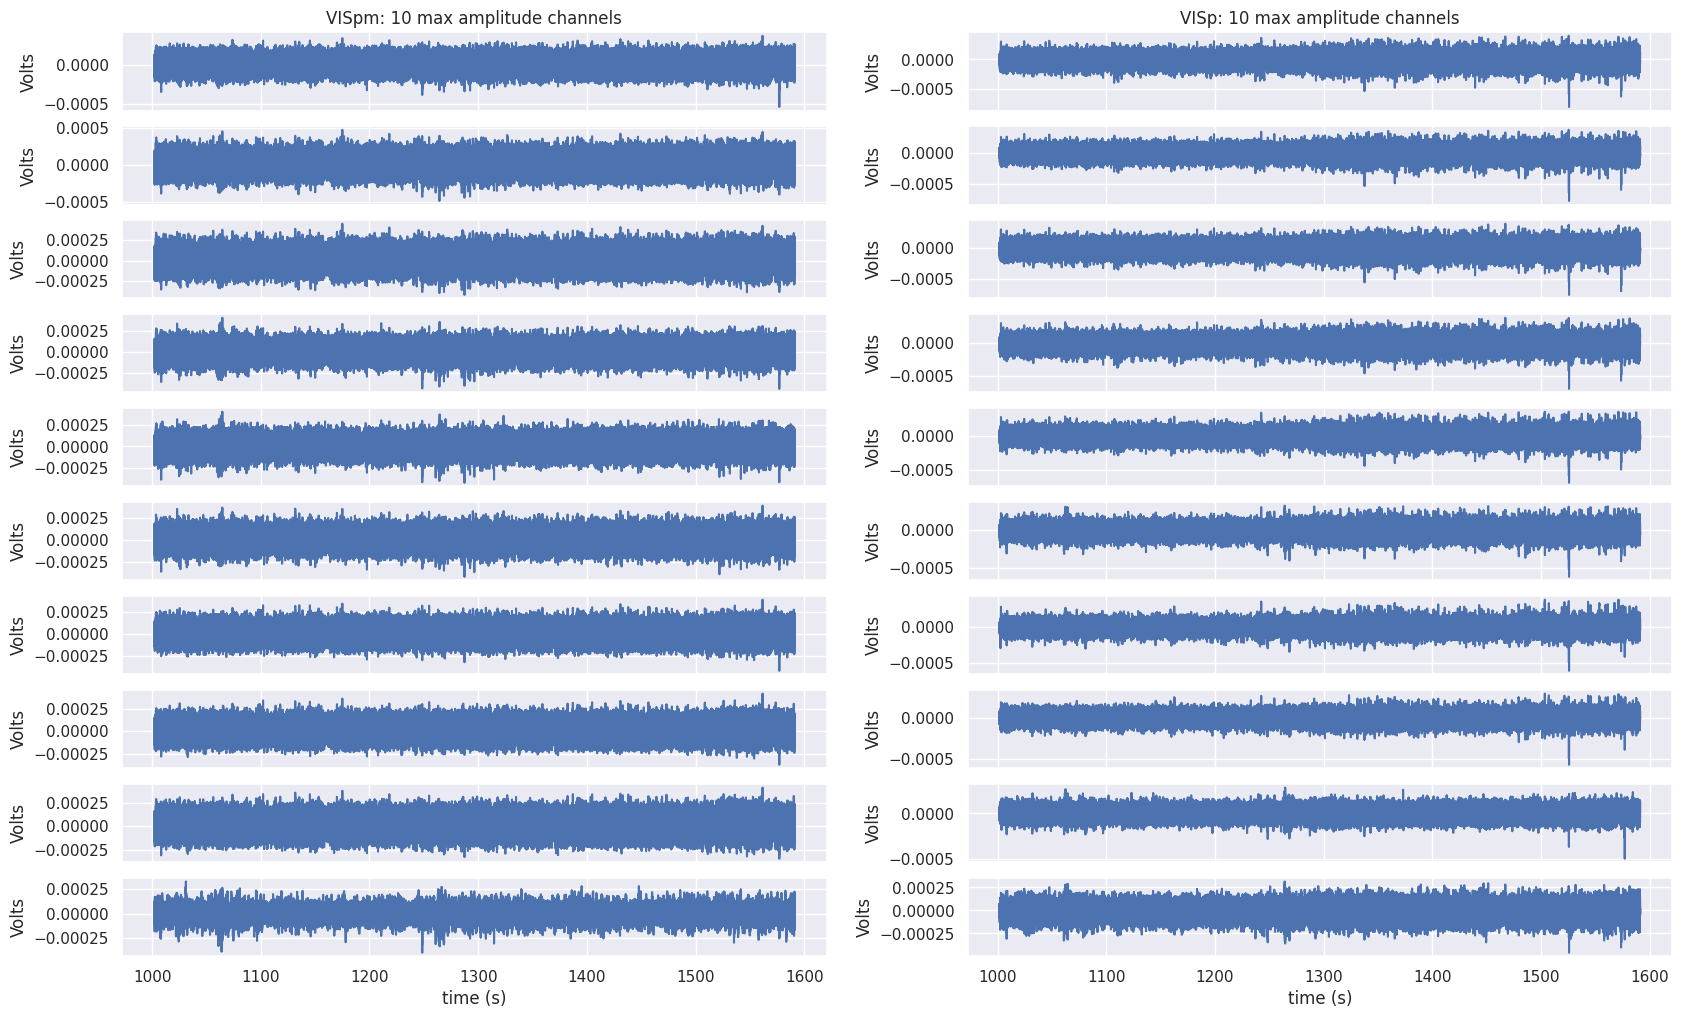

In [21]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(20, 12), sharex=True)
for i in range(10):
    axes[i][0].plot(VISpm_lfp_slice.time, VISpm_lfp_slice.sel(channel=VISpm_channel_ids[VISpm_max_channel_list[i]]))
    axes[i][0].set_ylabel(f'Volts')
axes[i][0].set_xlabel('time (s)')
axes[0][0].set_title('VISpm: 10 max amplitude channels')

for i in range(10):
    axes[i][1].plot(VISp_lfp_slice.time, VISp_lfp_slice.sel(channel=VISp_channel_ids[VISp_max_channel_list[i]]))
    axes[i][1].set_ylabel(f'Volts')
axes[i][1].set_xlabel('time (s)')
axes[0][1].set_title('VISp: 10 max amplitude channels')


plt.show()

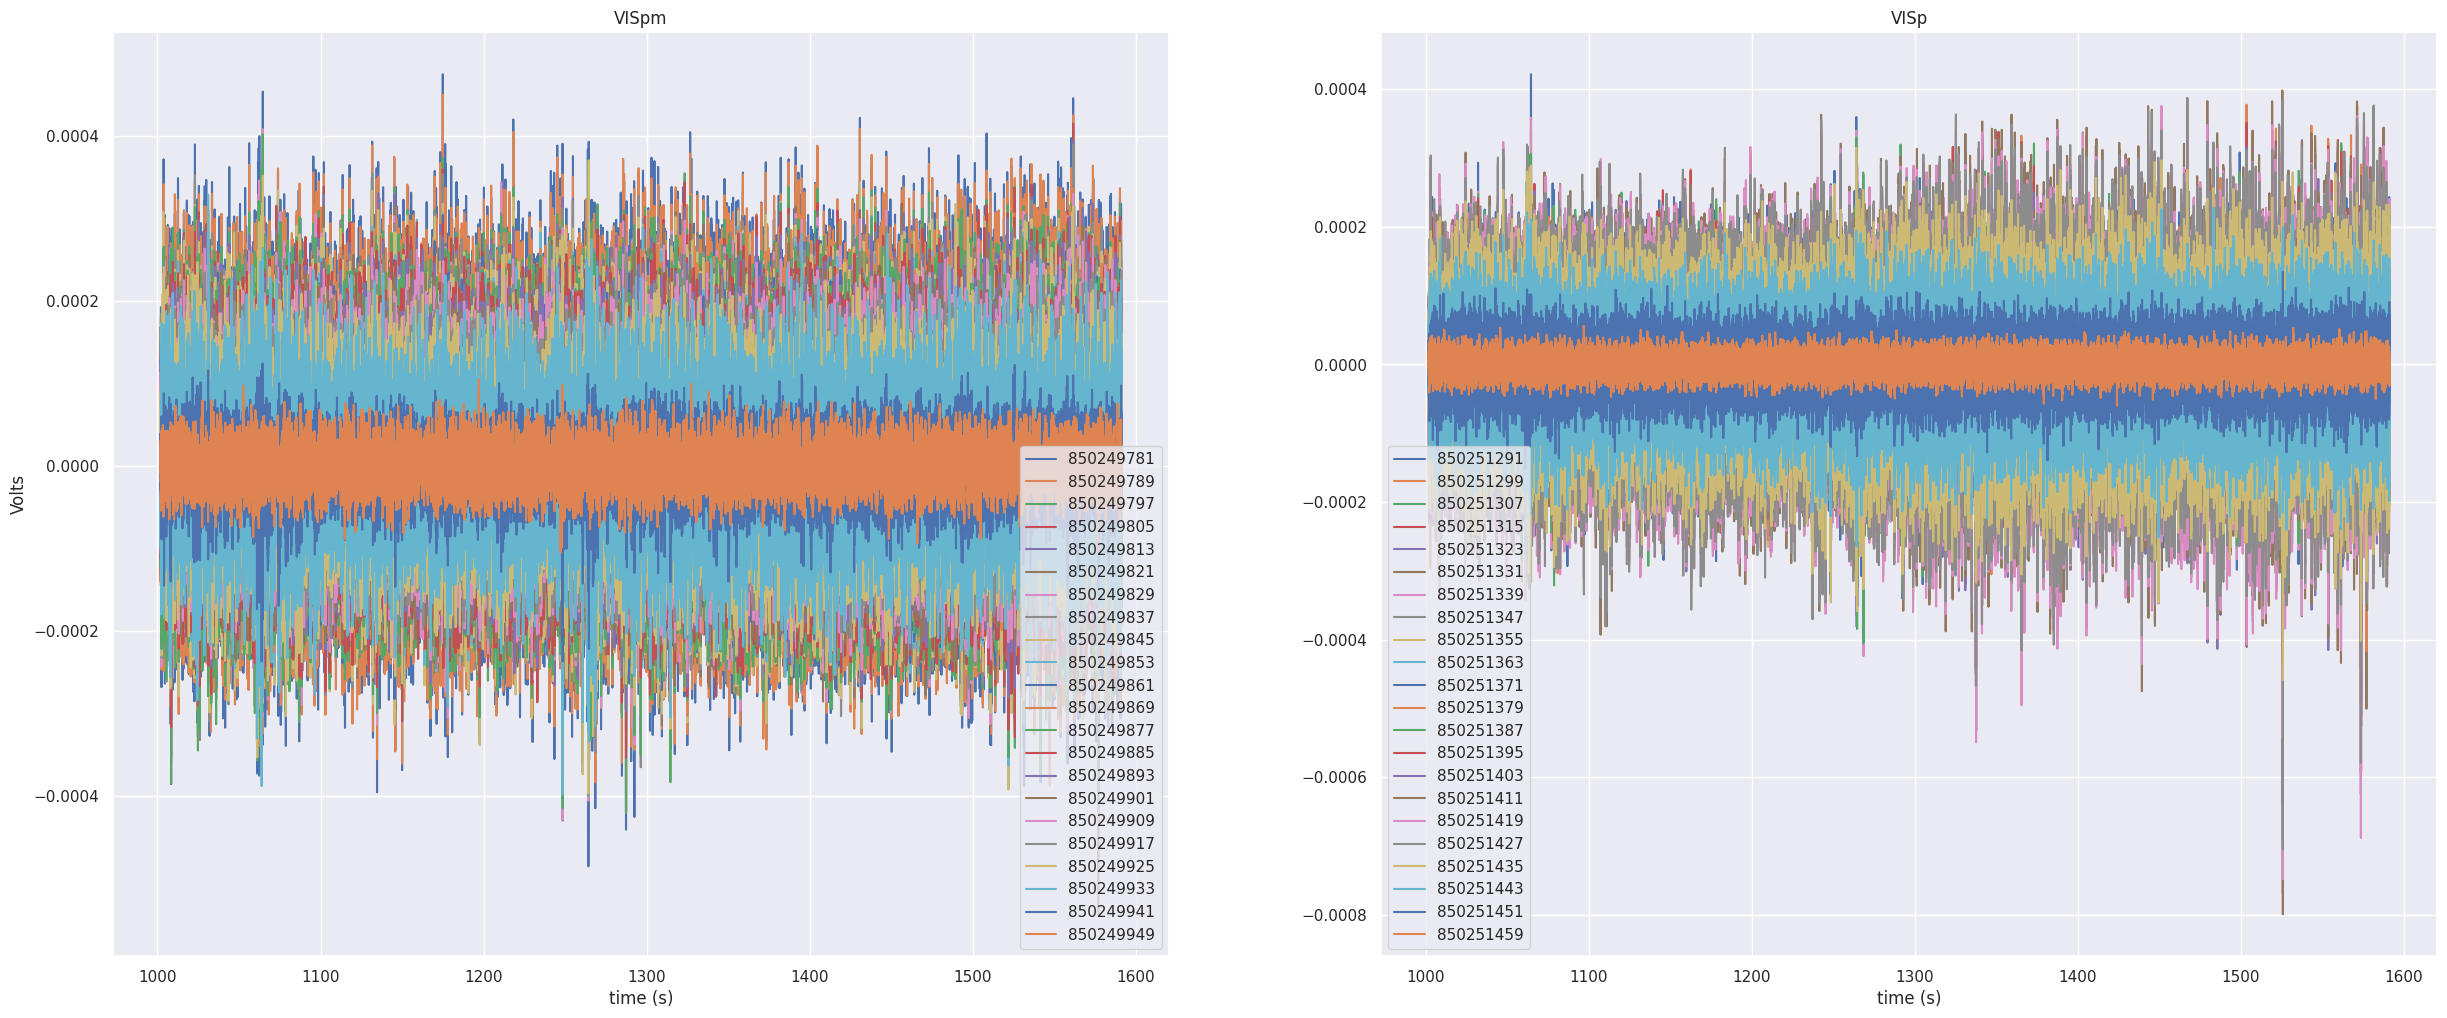

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12), sharex=True)
for i in range(len(VISpm_channel_ids)):
    axes[0].plot(VISpm_lfp_slice.time, VISpm_lfp_slice.sel(channel=VISpm_channel_ids[i]))
axes[0].set_ylabel(f'Volts')
axes[0].set_xlabel('time (s)')
axes[0].legend(VISpm_channel_ids)
axes[0].set_title('VISpm')

for i in range(len(VISp_channel_ids)):
    axes[1].plot(VISp_lfp_slice.time, VISp_lfp_slice.sel(channel=VISp_channel_ids[i]))
axes[1].set_xlabel('time (s)')
axes[1].legend(VISp_channel_ids)
axes[1].set_title('VISp')

plt.show()

In [23]:
# 5) Compute spectrogram from that channel

In [24]:
fs = 1250
freq_list = np.arange(1,100,9/100)
print(freq_list)

VISpm_wt_data = wavelet_transform(VISpm_lfp_slice.sel(channel=VISpm_max_channel), frequency=freq_list, sampling_frequency=fs)
VISp_wt_data = wavelet_transform(VISp_lfp_slice.sel(channel=VISp_max_channel), frequency=freq_list, sampling_frequency=fs)

[ 1.    1.09  1.18 ... 99.73 99.82 99.91]


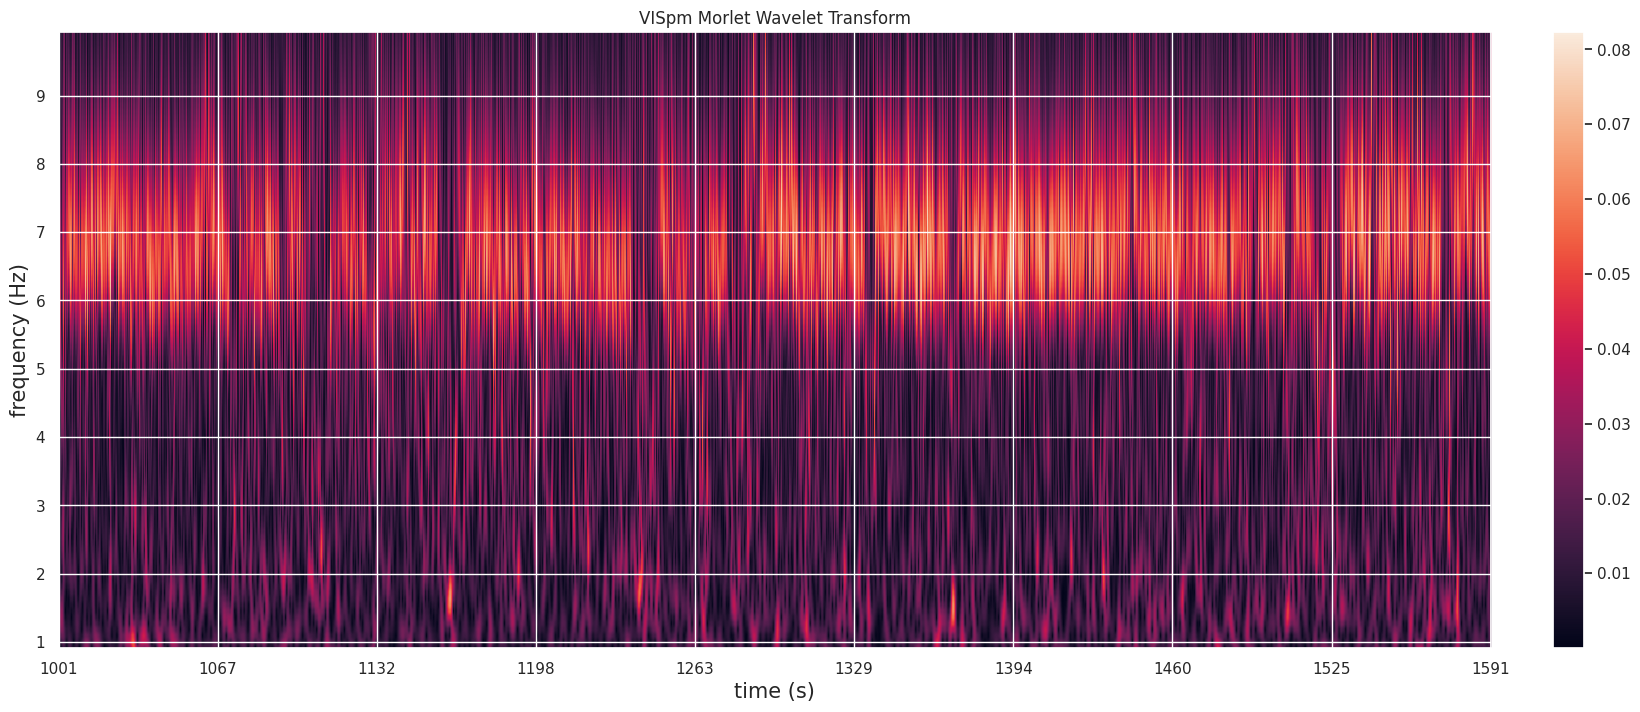

In [25]:
fig,ax = plt.subplots(figsize=(20,8))
im = ax.imshow(np.abs(VISpm_wt_data)[:,:],aspect='auto',origin='lower')

x_ticks_list = VISpm_lfp_slice.time.data

ax.set_xticks(np.linspace(0,VISpm_wt_data.shape[1],num=10))
ax.set_xticklabels(np.linspace(x_ticks_list[0],x_ticks_list[-1], num=10).astype(int))
ax.set_yticks(np.linspace(1,len(freq_list)-1,num=100))
ax.set_yticklabels(np.arange(1,101))

ax.set_xlabel("time (s)", fontsize=15)
ax.set_ylabel("frequency (Hz)", fontsize=15)

ax.set_title('VISpm Morlet Wavelet Transform')

fig.colorbar(im, fraction=0.036, pad=0.04)
# plt.xlim([1300,1330])
plt.ylim([0,freq_list[freq_list<10].shape[0]]) # get the number of datapoints from freq_list to set the limit for y axis

plt.show()

In [26]:
# 6) Compute binned PSD from that channel for the three (100-300-100) segments

Text(0, 0.5, 'power (V**2/Hz)')

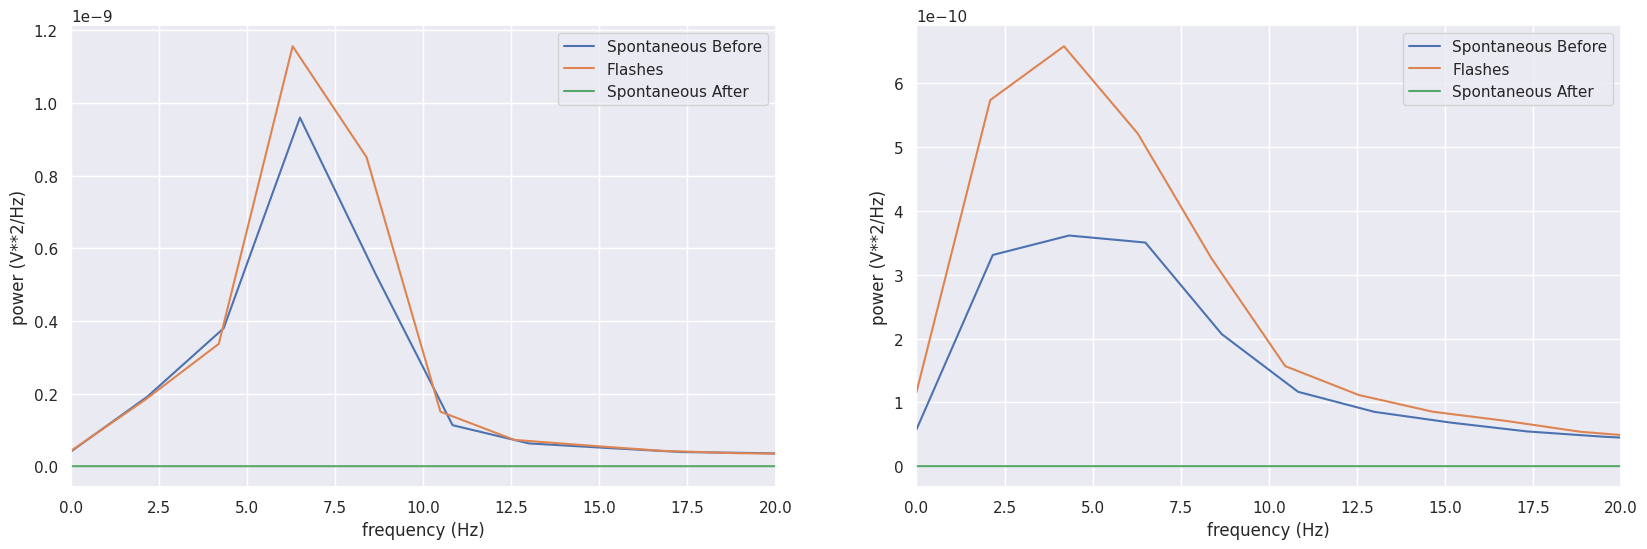

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

f1, psd1 = welch_psd(VISpm_lfp_slice.sel(channel=VISpm_max_channel).sel(time=slice(spontaneous_before_start_time, spontaneous_before_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)
f2, psd2 = welch_psd(VISpm_lfp_slice.sel(channel=VISpm_max_channel).sel(time=slice(flashes_start_time, flashes_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)
f3, psd3 = welch_psd(VISpm_lfp_slice.sel(channel=VISpm_max_channel).sel(time=slice(spontaneous_after_start_time, spontaneous_after_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)

# plt.semilogy(f, psd)

ax1.plot(f1,psd1)
ax1.plot(f2,psd2)
ax1.plot(f3,psd3)
ax1.legend(['Spontaneous Before','Flashes','Spontaneous After'])
ax1.set_xlim([0,20])
ax1.set_xlabel('frequency (Hz)')
ax1.set_ylabel('power (V**2/Hz)')

f1, psd1 = welch_psd(VISp_lfp_slice.sel(channel=VISp_max_channel).sel(time=slice(spontaneous_before_start_time, spontaneous_before_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)
f2, psd2 = welch_psd(VISp_lfp_slice.sel(channel=VISp_max_channel).sel(time=slice(flashes_start_time, flashes_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)
f3, psd3 = welch_psd(VISp_lfp_slice.sel(channel=VISp_max_channel).sel(time=slice(spontaneous_after_start_time, spontaneous_after_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)

# plt.semilogy(f, psd)

ax2.plot(f1,psd1)
ax2.plot(f2,psd2)
ax2.plot(f3,psd3)
ax2.legend(['Spontaneous Before','Flashes','Spontaneous After'])
ax2.set_xlim([0,20])
ax2.set_xlabel('frequency (Hz)')
ax2.set_ylabel('power (V**2/Hz)')

# plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')

In [28]:
f1

array([  0.        ,   2.16637782,   4.33275563,   6.49913345,
         8.66551127,  10.83188908,  12.9982669 ,  15.16464471,
        17.33102253,  19.49740035,  21.66377816,  23.83015598,
        25.9965338 ,  28.16291161,  30.32928943,  32.49566724,
        34.66204506,  36.82842288,  38.99480069,  41.16117851,
        43.32755633,  45.49393414,  47.66031196,  49.82668977,
        51.99306759,  54.15944541,  56.32582322,  58.49220104,
        60.65857886,  62.82495667,  64.99133449,  67.15771231,
        69.32409012,  71.49046794,  73.65684575,  75.82322357,
        77.98960139,  80.1559792 ,  82.32235702,  84.48873484,
        86.65511265,  88.82149047,  90.98786828,  93.1542461 ,
        95.32062392,  97.48700173,  99.65337955, 101.81975737,
       103.98613518, 106.152513  , 108.31889081, 110.48526863,
       112.65164645, 114.81802426, 116.98440208, 119.1507799 ,
       121.31715771, 123.48353553, 125.64991334, 127.81629116,
       129.98266898, 132.14904679, 134.31542461, 136.48

In [29]:
# 7) For other areas recorded in VISp and VISpm probes, repeat Step 5.